Xception

In [12]:
# Libraries
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [13]:
def preprocess_image(image_path, size=(224, 224)):
    img = Image.open(image_path)
    
    # Quality enhancement
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(2.0)  # Increase sharpness
    
    # Noise reduction
    image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Consistency
    img = img.resize(size, Image.LANCZOS)
    
    # Normalization
    img_array = np.array(img) / 255.0
    
    # Convert back to image
    img = Image.fromarray((img_array * 255).astype(np.uint8))
    
    return img

# Apply preprocessing and save to new directory
input_dir = 'data/images_train_test_val/train'
output_dir = 'data/processed_images'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):
        output_category_path = os.path.join(output_dir, category)
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            preprocessed_img = preprocess_image(image_path)
            preprocessed_img.save(os.path.join(output_category_path, image_name))

Check for Image Corruption

In [14]:
from PIL import UnidentifiedImageError

def check_images(directory):
    corrupted_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # This will raise an exception if the image is corrupted
            except (UnidentifiedImageError, IOError) as e:
                corrupted_images.append(file_path)
                print(f"Corrupted image: {file_path} - {e}")
    return corrupted_images

corrupted_images = check_images('images')
print(f"Total corrupted images: {len(corrupted_images)}")


Total corrupted images: 0


In [15]:
train_dir = 'data/processed_images'
val_dir = 'data/images_train_test_val/validation'
test_dir = 'data/images_train_test_val/test'

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 7350 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.


In [16]:
def create_xception_model(input_shape=(224, 224, 3), num_classes=21, l2_rate=0.01):
    # Create the base pre-trained model
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.6)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.6)(x)
    predictions = Dense(21, activation='softmax')(x)

    # Construct the full model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create the Xception model
model = create_xception_model()

In [17]:
import json
import os

class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, file_path):
        super(SaveHistoryCallback, self).__init__()
        self.file_path = file_path
        # Create the file initially or clear existing file
        if not os.path.exists(file_path):
            with open(file_path, 'w') as f:
                json.dump({}, f)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        with open(self.file_path, 'r+') as f:
            history = json.load(f)
            for key, value in logs.items():
                if key in history:
                    history[key].append(value)
                else:
                    history[key] = [value]
            f.seek(0)  # Go to the beginning of the file
            json.dump(history, f, indent=4)

In [18]:
# Define callbacks
checkpoint = ModelCheckpoint(
    'models/best_Xception_model.keras', 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min',
    verbose=1
    )

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    mode='min',
    verbose=1,
    restore_best_weights=True
    )

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=1e-6
    )


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr, SaveHistoryCallback('models/xception_history.json')]
)


Epoch 1/20


/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0958 - loss: 5.4453
Epoch 1: val_loss improved from inf to 3.59251, saving model to models/best_Xception_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 478s 4s/step - accuracy: 0.0964 - loss: 5.4402 - val_accuracy: 0.3586 - val_loss: 3.5925 - learning_rate: 1.0000e-04
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3232 - loss: 3.6253
Epoch 2: val_loss improved from 3.59251 to 2.71011, saving model to models/best_Xception_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 459s 4s/step - accuracy: 0.3235 - loss: 3.6235 - val_accuracy: 0.6281 - val_loss: 2.7101 - learning_rate: 1.0000e-04
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4593 - loss: 3.0398
Epoch 3: val_loss improved from 2.71011 to 2.14236, saving model to models/best_Xception_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 485s 4s/step - accuracy: 0.4595 - loss: 3.0387 - val_accuracy: 0.7324 - val_loss: 2.1424 - learning_rate: 1.0000e-04
Epoch 4/20
115/115 

In [19]:
# Load the best model
model.load_weights('models/best_Xception_model.keras')

# Evaluate the model
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)
test_loss, test_acc = model.evaluate(test_generator)

print(f'Train accuracy: {train_acc:.4f}, Validation accuracy: {val_acc:.4f}, Test accuracy: {test_acc:.4f}')

 33/115 ━━━━━━━━━━━━━━━━━━━━ 4:43 3s/step - accuracy: 0.8960 - loss: 1.3388

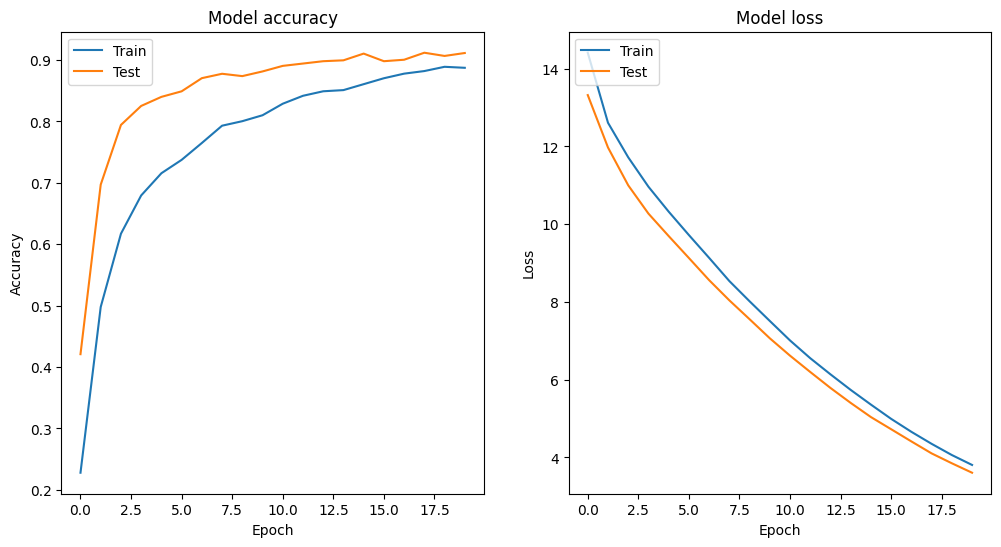

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


17/17 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step


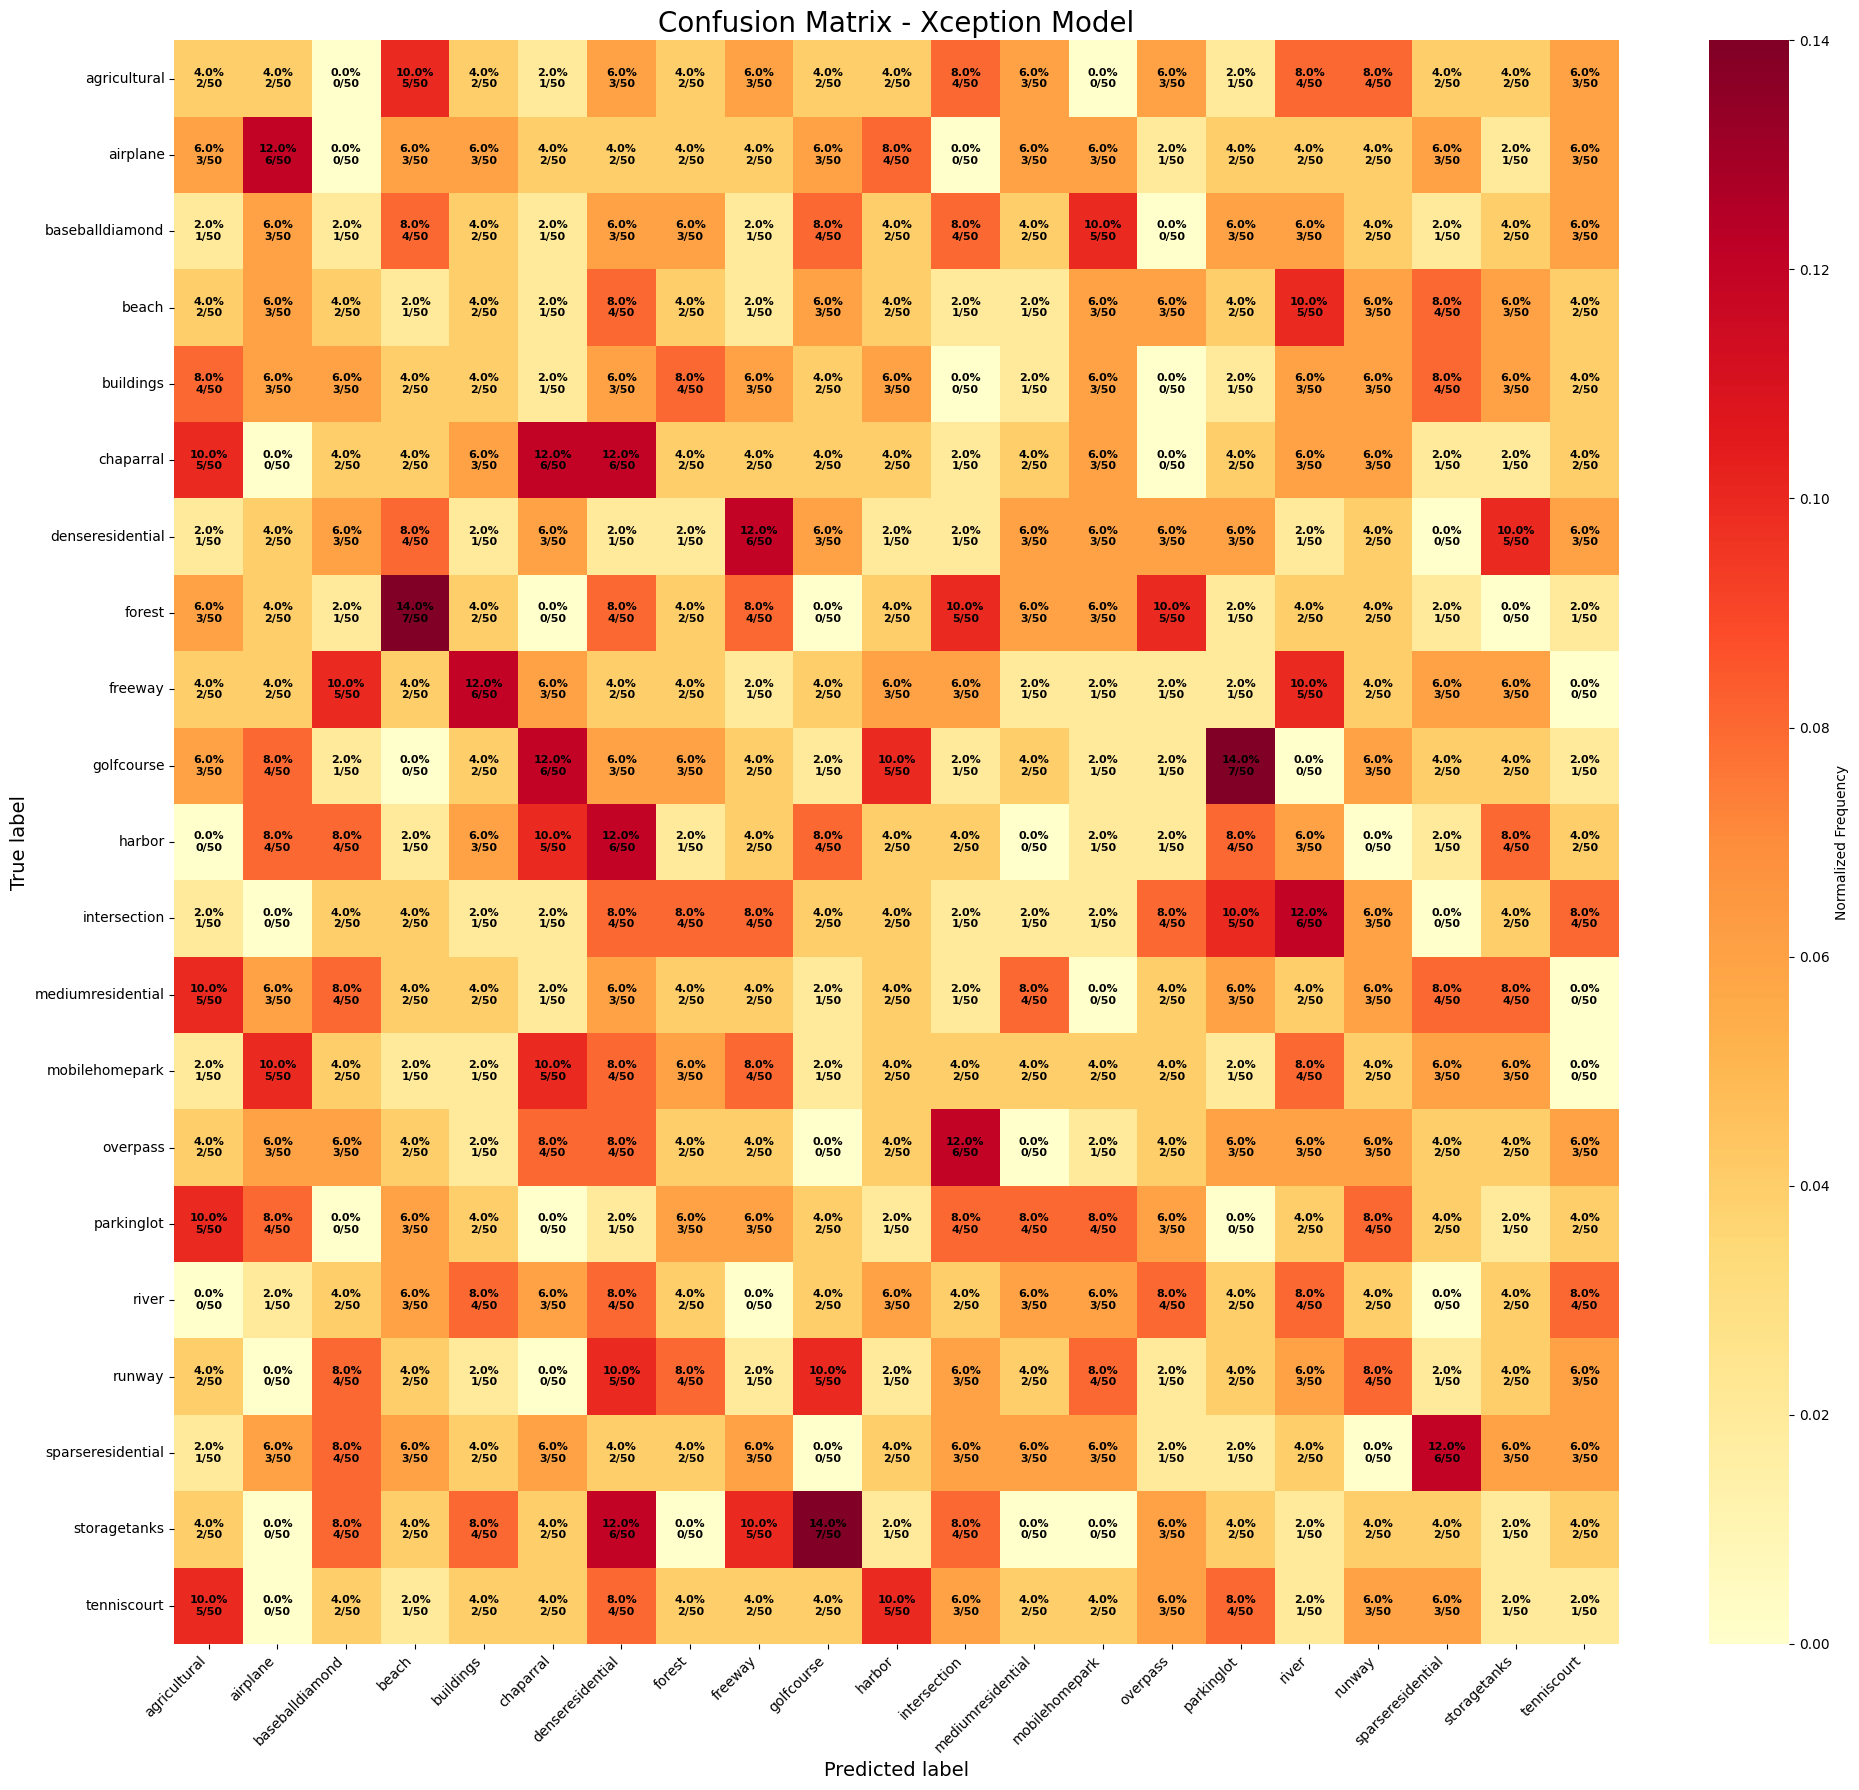

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

# Load the best model (assuming you've saved it during training)
model = load_model('models/best_Xception_model.keras')

# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a figure and axis
plt.figure(figsize=(20, 18))

# Plot the heatmap
sns.heatmap(cm_normalized, annot=False, cmap='YlOrRd', 
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Normalized Frequency'})

# Customize the plot
plt.title('Confusion Matrix - Xception Model', fontsize=20)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Add text annotations for percentages and absolute values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j+0.5, i+0.5, f"{cm_normalized[i, j]:.1%}\n{cm[i, j]}/{cm[i, :].sum()}", 
                 ha="center", va="center", color="black" if cm_normalized[i, j] < 0.5 else "white", 
                 fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()